In [21]:
#imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf

analyzer = SentimentIntensityAnalyzer()

For this project we will be classifying the complete works of William Shakespeare. The dataset used is from Kaggle. The final goal of the project is to classify the player, or speaker, by the other features. 

In [6]:
#reading in csv
df = pd.read_csv("../data/Shakespeare_data.csv")
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


Looking at the head of the dataset, we see that everything is in the dataset given from the works of Shakespeare, this includes titles like ACT 1 and also setting descriptors and stage directions. For classification, this will most likely hinder a conclusion, thus it makes the most sense to remove any titles, stage directions, or lines that set the scene. These are most evidently shown by having NaN for player actsceneline and playerlinenmber. Below I am doing the cleaning of taking out any entries that don't have a player, because that is what we are classifying and then taking out those data points earlier disussed. 

In [7]:
#do the cleaning
df.dropna(subset=["Player"], inplace=True)

df.dropna(thresh=3, subset=["PlayerLinenumber", "ActSceneLine", "Player"], inplace=True)
#dataline doesnt mean much just gives a counter of data, which is trivially found with index
df.drop(["Dataline"], axis=1, inplace=True)
df

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
3,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
5,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils
6,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.
7,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil
...,...,...,...,...,...
111390,A Winters Tale,38.0,5.3.179,LEONTES,"Is troth-plight to your daughter. Good Paulina,"
111391,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
111392,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
111393,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first


Before diving into any code, let's first do some exploratory data analysis on the data set and see how many players there are, how many plays there are. How many lines each player has. How many words each player says. How many scenes

In [8]:
len(df["Player"].unique())

934

In [9]:
#getting num and unique for plays and players
num_chars = len(df.Player.unique())
all_chars = df.Player.unique()
num_plays = len(df.Play.unique())
all_plays = df.Play.unique()

char_word_count = []
line_numbers = []
char_act_scene = []

df.loc[df["Player"] == "LEONTES"]

for character in all_chars:
    char_df = df.loc[df["Player"] == character]
    line_numbers.append(len(char_df["PlayerLinenumber"].unique()))
    char_act_scene.append(len(char_df["ActSceneLine"].unique()))
    total_word_count = 0
    for p_object in char_df.itertuples():
        total_word_count += len(p_object.PlayerLine)
    char_word_count.append(total_word_count)


Now we have collected a bunch of data. We have collected who the characters in the plays are, the plays that there are, lets plot some of the data we have gathered

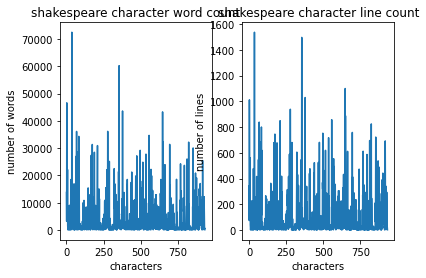

In [10]:
x = [i for i in range(num_chars)]
y1 = char_word_count
y2 = char_act_scene

plt.subplot(1, 2, 1)

plt.plot(x, y1)
plt.xlabel("characters")
plt.ylabel("number of words")
plt.title('shakespeare character word count')

plt.subplot(1, 2, 2)
plt.plot(x, y2)
plt.xlabel("characters")
plt.ylabel("number of lines")
plt.title('shakespeare character line count')

plt.rcParams["figure.figsize"] = (20,3)
plt.show()

From our exploratory data analysis we can see that such attributes like line count and also word count are good indicators of who the character speaking would be, the reason for this is just based off the high variety of the values. Instead of using nlp right away for what the characters are saying, potentially a good source of data for classification would be word count in the line and also what line the would be on. Thus, we should do some more data cleaning/adding.

Features to use for classification of the characters:

• What line the character is reading from

• What play they are in

• How many words they are saying

• The sentiment of their words


*** The reason for adding sentiment is because it is relatively easy to figure out the sentiment, and you then do not have to figure out more difficult problems of NLP. For example, if I were to do a Neural Network with the words, I would then not have to include an embedding layer etc. Hopefully this will get me enough features to then be able to correclty classify

In [11]:
thing = df["ActSceneLine"].str.split(".")
df["Act"] = thing.map(lambda x: x[0])
df["Scene"] = thing.map(lambda x: x[1])
df["Line_"] = thing.map(lambda x: x[2])
df

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Line_
3,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1
4,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",1,1,2
5,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils,1,1,3
6,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.,1,1,4
7,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil,1,1,5
...,...,...,...,...,...,...,...,...
111390,A Winters Tale,38.0,5.3.179,LEONTES,"Is troth-plight to your daughter. Good Paulina,",5,3,179
111391,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely",5,3,180
111392,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part,5,3,181
111393,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first,5,3,182


In [12]:
#Adding/Cleaning features

LE = LabelEncoder()

#adding sentiment of the line
df["LineSentiment"] = df["PlayerLine"].apply(analyzer.polarity_scores)
df["WordCount"] = df["PlayerLine"].str.split().apply(len)
df["Play_ID"] = LE.fit_transform(df["Play"])
df["PLineNumberID"] = LE.fit_transform(df["PlayerLinenumber"])
df["Player_ID"] = LE.fit_transform(df["Player"])
# df["SceneLine_ID"] = LE.fit_transform(df["ActSceneLine"])

df.drop(["PlayerLine","Play", "PlayerLinenumber", "Player", "ActSceneLine"], axis=1, inplace=True)
df

,Act,Scene,Line_,LineSentiment,WordCount,Play_ID,PLineNumberID,Player_ID
3,1,1,1,"{'neg': 0.132, 'neu': 0.581, 'pos': 0.287, 'co...",9,9,0,457
4,1,1,2,"{'neg': 0.186, 'neu': 0.543, 'pos': 0.271, 'co...",9,9,0,457
5,1,1,3,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",7,9,0,457
6,1,1,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",7,9,0,457
7,1,1,5,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",8,9,0,457
...,...,...,...,...,...,...,...,...
111390,5,3,179,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",7,2,37,494
111391,5,3,180,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",8,2,37,494
111392,5,3,181,"{'neg': 0.176, 'neu': 0.824, 'pos': 0.0, 'comp...",8,2,37,494
111393,5,3,182,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",9,2,37,494


In [13]:
#getting the compound of the Sentiment
df["LineSentiment"] = df["LineSentiment"].apply(lambda x: x.get("compound"))

In [14]:
scaler = MinMaxScaler()

df[["Act", "Scene", "Line_", "WordCount", "Play_ID", "PLineNumberID"]] = \
    scaler.fit_transform(df[["Act", "Scene", "Line_", "WordCount", "Play_ID", "PLineNumberID"]])
df

,Act,Scene,Line_,LineSentiment,WordCount,Play_ID,PLineNumberID,Player_ID
3,0.2,0.066667,0.000000,0.4349,0.054795,0.257143,0.000000,457
4,0.2,0.066667,0.001031,0.2732,0.054795,0.257143,0.000000,457
5,0.2,0.066667,0.002062,0.0000,0.041096,0.257143,0.000000,457
6,0.2,0.066667,0.003093,0.0000,0.041096,0.257143,0.000000,457
7,0.2,0.066667,0.004124,-0.2960,0.047945,0.257143,0.000000,457
...,...,...,...,...,...,...,...,...
111390,1.0,0.200000,0.183505,0.4404,0.041096,0.057143,0.091584,494
111391,1.0,0.200000,0.184536,0.0000,0.047945,0.057143,0.091584,494
111392,1.0,0.200000,0.185567,-0.1280,0.047945,0.057143,0.091584,494
111393,1.0,0.200000,0.186598,0.0000,0.054795,0.057143,0.091584,494


Now that we finished creating the features and putting them in the right format, we can then start trying to classify them. Some classification methods to try would be:

• Decision Tree

• Naive Bayes

• Linear Regression

• Random Forrest

• Neural Network

In [15]:
#Data for classifiers
X = np.array(df.drop("Player_ID", axis=1))
y = np.array(df["Player_ID"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
#Naive Bayes
naive_model = GaussianNB()
naive_model.fit(X_train, y_train)
naive_model.score(X_test, y_test)

0.22119728020541107

In [17]:
#Decision Tree
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_model.score(X_test, y_test)

0.7243592791593362

In [18]:
#random forrest
forrest_model = RandomForestClassifier(n_jobs=4, random_state=0)
forrest_model.fit(X_train, y_train)
forrest_model.score(X_test, y_test)

0.7380058009604868

In [19]:
#linear regression
lin_model = LinearRegression(n_jobs=-1)
lin_model.fit(X_train, y_train)
lin_model.score(X_test, y_test)

0.013797820309808473

In [ ]:
nn_model = Sequential()

nn_model.add(Dense(32, activation="relu", input_shape=(7,)))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(200, activation="relu"))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(128, activation="relu"))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(935, activation="softmax"))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
nn_model.compile(loss='sparse_categorical_crossentropy',
                              optimizer=opt,
                              metrics=["accuracy"])

# model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))
nn_model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
1315/1315 [==============================] - 3s 2ms/step - loss: 5.2722 - accuracy: 0.0436 - val_loss: 4.5350 - val_accuracy: 0.0830
Epoch 2/15
1315/1315 [==============================] - 3s 2ms/step - loss: 4.3811 - accuracy: 0.0816 - val_loss: 3.9002 - val_accuracy: 0.1420
Epoch 3/15
1315/1315 [==============================] - 3s 2ms/step - loss: 4.0173 - accuracy: 0.1043 - val_loss: 3.5658 - val_accuracy: 0.1734
Epoch 4/15
1315/1315 [==============================] - 3s 2ms/step - loss: 3.8127 - accuracy: 0.1187 - val_loss: 3.3524 - val_accuracy: 0.1970
Epoch 5/15
1315/1315 [==============================] - 3s 2ms/step - loss: 3.6521 - accuracy: 0.1349 - val_loss: 3.1701 - val_accuracy: 0.2315
Epoch 6/15
1315/1315 [==============================] - 3s 2ms/step - loss: 3.5259 - accuracy: 0.1480 - val_loss: 3.0504 - val_accuracy: 0.2439
Epoch 7/15
1315/1315 [==============================] - 3s 2ms/step - loss: 3.4294 - accuracy: 0.1576 - val_loss: 2.9591 - val_accuracy:

Results:
After taking the data and cleaning it, adding the features of 1) act 2) scene 3) line number and 4) line sentiment, and finally scaling the data, we had acceptable data to train on. From those results we had to use the data to then try and clasify 934 characters in all of Shakespeare's plays. I tested 5 different models. I tested the five stated above. The best results from each are as follows:
• Decision Tree = 71%

• Naive Bayes = 22%

• Linear Regression = 1.4%

• Random Forrest = 74%

• Neural Network = 30%

The best model that I used from the data I extracted was by using a random forrest model, with a correct percentage of 74%. 